In [108]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator

from qiskit_ibm_runtime import Session, SamplerV2 as Sampler, QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import random
import math
import numpy as np
import matplotlib.pyplot as plt

from helper_functions_tsp import read_file_name, validate_distance_array
from helper_functions_tsp import find_problem_size, find_stats

In [109]:
LOCATIONS = 4                 #number of locations to be visited
VERBOSE = False               #controls how much is printed
TOLERANCE = 1e-1              #Tolerance
SHOTS = 1024
#RELEVANT_VALUES = 50         #controls how many of the items to average over as a percentage
                              #eg 100 = all 
                              #30 = top 30%
#LEARNING_RATE = 1e-2         #learning rate
#UPDATES = 100                #updates, or iterations
#PRINT_FREQUENCY = 20         #how often results are printed out
#SPSA = False                 #SPSA stochastic gradient descent used
#DEBUG = False                #Extra data printed out

From the number of locations visited find the qubits and longest binary string.

In [110]:
bin_len, qubits = find_problem_size(LOCATIONS)
print(f'There are {qubits} qubits needed.  The longest binary string is {bin_len}')

There are 3 qubits needed.  The longest binary string is 2


Data sources are held locally to avoid downstream dependencies.

In [111]:
data_sources = {  4 : {'file' : 'data/four_d.txt', 'best' : 21},
                  5 : {'file' : 'data/five_d.txt', 'best' : 19},
                 11 : {'file' : 'data/dg11_d.txt', 'best' : 253},
                 15 : {'file' : 'data/p01_d.txt',  'best' : 291},
                 17 : {'file' : 'data/gr17_d.txt', 'best' : 2085},
                 26 : {'file' : 'data/fri26_d.txt', 'best' : 699},
                 42 : {'file' : 'data/dantzig42_d.txt', 'best' : 33_523},
                }

In [112]:
filename = read_file_name(LOCATIONS, data_sources)
best = data_sources[LOCATIONS]['best']
print(f'Data will be read from filename {filename}.  It is known that the shortest distance is {best}.')

Data will be read from filename data/four_d.txt.  It is known that the shortest distance is 21.


In [113]:
# may not be needed.
#from qiskit_algorithms.optimizers import COBYLA

Read and validate the distance array.  This checks the array is the correct shape, and is symmetric.

In [114]:
distance_array = np.genfromtxt(filename)
validate_distance_array(distance_array, LOCATIONS)

In [115]:
def initialise_parameters(qubits):
    #initialise parameter text
    init_params = []
    for i in range(qubits):
        text1 = "weight" + str(2*i)
        text2 = "weight" + str(2*i +1 )
        init_params.append(Parameter(text1 ))
        init_params.append(Parameter(text2 ))
    #initialise parameters with random weights    
    for i in range(qubits * 2):
        init_params[i] = random.random() * 2 * math.pi
        if VERBOSE:
            print(init_params[i])
    return init_params

In [116]:
def vqc_circuit(qubits, params):
    #set up a variational quantum circuit
    qc = QuantumCircuit(qubits)
    for i in range(qubits):
        qc.h(i)
        qc.ry(params[2*i], i)
        qc.rx(params[2*i+1], i)
    for i in range(qubits-1):
            qc.cx(i,i+1)
    qc.measure_all()
    return qc

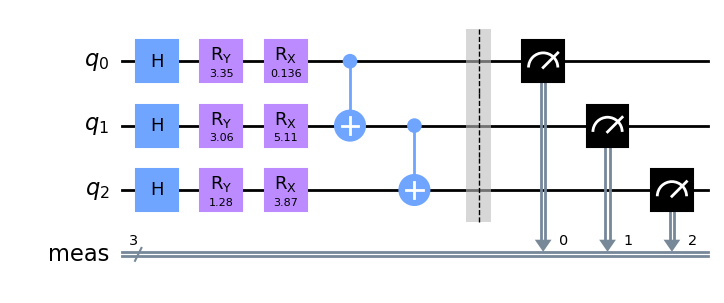

In [117]:
init_params = initialise_parameters(qubits)

#calculate and draw first circuit
qc = vqc_circuit(qubits, init_params)

#draw the first circuit
qc.draw("mpl", style="clifford")

In [118]:
# Run the sampler job locally using AerSimulator.
# Session syntax is supported but ignored because local mode doesn't support sessions.
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
# transpilation - not needed yet, included for later
isa_qc = pm.run(qc)
# session is not needed yet.  Included for later.
with Session(backend=aer_sim) as session:
    sampler = Sampler()
    result = sampler.run([isa_qc]).result()
    counts = result[0].data.meas.get_counts()
    print('The measurement with the initial parameters are:')
    print(counts)
    cost, lowest = find_stats(counts, LOCATIONS, distance_array, SHOTS)
    print(f'This gives an average cost of {cost},and a lowest distance of {lowest}.')

The measurement with the initial parameters are:
{'111': 164, '010': 49, '001': 192, '110': 254, '100': 46, '000': 255, '011': 27, '101': 37}
This gives an average cost of 21.37109375,and a lowest distance of 21.0.


In [119]:
print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=3>)), metadata={'shots': 1024, 'circuit_metadata': {}})], metadata={'version': 2})


In [120]:
def cost_func_evaluate(params):
    with Session(backend=aer_sim) as session:
        sampler = Sampler()
        result = sampler.run([isa_qc]).result()
        counts = result[0].data.meas.get_counts()
        cost, lowest = find_stats(counts, LOCATIONS, distance_array, SHOTS)
        print(f'Cost is {cost}, Lowest is {lowest}, params are {params}')
    return(cost)

In [121]:
from scipy.optimize import minimize

In [123]:
graph_list = []
result = minimize(
    cost_func_evaluate,
    init_params,
    method="COBYLA",
    tol=TOLERANCE
    )

Cost is 21.35546875, Lowest is 21.0, params are [3.35283657 0.13595276 3.0640298  5.11039103 1.28432344 3.87335722]
Cost is 21.375, Lowest is 21.0, params are [4.35283657 0.13595276 3.0640298  5.11039103 1.28432344 3.87335722]
Cost is 21.3359375, Lowest is 21.0, params are [3.35283657 1.13595276 3.0640298  5.11039103 1.28432344 3.87335722]
Cost is 21.375, Lowest is 21.0, params are [3.35283657 1.13595276 4.0640298  5.11039103 1.28432344 3.87335722]
Cost is 21.41015625, Lowest is 21.0, params are [3.35283657 1.13595276 3.0640298  6.11039103 1.28432344 3.87335722]
Cost is 21.34765625, Lowest is 21.0, params are [3.35283657 1.13595276 3.0640298  5.11039103 2.28432344 3.87335722]
Cost is 21.296875, Lowest is 21.0, params are [3.35283657 1.13595276 3.0640298  5.11039103 1.28432344 4.87335722]
Cost is 21.2734375, Lowest is 21.0, params are [3.15203174 1.33675759 2.66242013 4.34733267 1.16384054 5.27496689]
Cost is 21.33984375, Lowest is 21.0, params are [2.85956676 1.62922256 2.07749018 4.68

In [103]:
av_dist = result['fun']
print(f'The lowest average distance found is {av_dist}, compared to a known minimum of {best}')

The lowest average distance found is 22.37890625, compared to a known minimum of 21


In [104]:
for key, item in result.items():
    print(key, item)


x [2.41286542 2.0167003  5.24107682 4.2542155  4.13182476 3.13439437]
status 1
success True
message Optimization terminated successfully.
nfev 25
fun 22.37890625
maxcv 0.0


In [98]:
#arr = np.array(graph_list)
#n = len(graph_list)
#av = arr[:,0]
#low = arr[:,1]
#x = np.linspace(1, n, num=n)


In [99]:
#import matplotlib.pyplot as plt
#plt.style.use('_mpl-gallery')

#plt.plot(x, av, linewidth=1.0)
#plt.step(x, low, linewidth=1.0)
# plot
#plt.grid(axis='x', color='0.95')
#plt.title('Average distance and lowest distance found')
#plt.show()


In [100]:
#param_vals = init_params
#sampler = Sampler()
#sampler = StatevectorSampler
#gradient = ParamShiftSamplerGradient(sampler)

#qc_sample = vqc_circuit(qubits, param_vals)
##pss_grad_result = gradient.run(qc_sample, [param_vals]).result().gradients
#print("State sampler gradient computed with parameter shift", pss_grad_result)

NameError: name 'pss_grad_result' is not defined

In [31]:
#from qiskit.primitives import Sampler
#from qiskit_algorithms.gradients import ParamShiftSamplerGradient

#param_vals = [[np.pi / 4, np.pi / 2]]
#sampler = Sampler()
#gradient = ParamShiftSamplerGradient(sampler)
#pss_grad_result = gradient.run(qc_sample, param_vals).result().gradients
#print("State sampler gradient computed with parameter shift", pss_grad_result)

State sampler gradient computed with parameter shift [[{0: 0.35355339059327384, 1: -0.35355339059327384}, {0: 0.0, 1: 0.0}]]


C:\Users\DanielGoldsmith\AppData\Local\Temp\ipykernel_12920\961213124.py:5: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
